In [1]:
from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os
from tqdm import tqdm

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.transform.geometry_transformation import pol2cart, cart2pol
from cell_inference.cells.simulation import Simulation
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.utils.currents.ecp import EcpMod, EcpCell
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.plotting.plot_morphology import plot_morphology
from cell_inference.utils.feature_extractors.SummaryStats2D import process_lfp, scaled_stats_indices
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

## Load data

In [2]:
invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikeWaveforms_NP_SUTempFilter_NPExample'
# invivo_name = 'all_cell_LFP2D_Analysis_SensorimotorSpikes_NPUnits_large.h5'

INVIVO_PATH = 'cell_inference/resources/invivo'
INVIVO_LFP_PATH = os.path.join(INVIVO_PATH, 'lfp_' + invivo_name + '.npz')  # LFP and labels
INVIVO_STATS_PATH = os.path.join(INVIVO_PATH, 'summ_stats_' + invivo_name + '.npz')  # summary statistics

invivo_stats = np.load(INVIVO_STATS_PATH)['x']
layer = np.load(INVIVO_STATS_PATH)['layer']
y_c = np.load(INVIVO_STATS_PATH)['yc']

scaled_idx = scaled_stats_indices()
invivo_stats[:, scaled_idx] *= 1e-3  # from uV to mV

In [3]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Reduced_Order_trunklength_Loc5_restrict_h') # select trial

STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics
STATS = np.load(STATS_PATH)
summ_stats = STATS['x']
n_summ_stats = summ_stats.shape[1]

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
loc_param_list = config_dict['Simulation_Parameters']['loc_param_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'h', 'phi', 'l_t']


### Transform labels

#### Orientation

In [4]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
#     orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
#     orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [5]:
has_yshift = 'y' in label_list
if has_yshift:
    ys_idx = label_list.index('y')
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'
    ranges['ys'] = [-150, 150] # set bound for normalization
    y_idx = loc_param_list.index('y')

#### Normalization

In [6]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

### Get magnitude distribution

In [7]:
max_mag_idx = scaled_idx[[-4, -1]]
max_mag = np.amax(summ_stats[:, max_mag_idx], axis=1)
max_mag_invivo = np.amax(invivo_stats[:, max_mag_idx], axis=1)
mag_scale = np.mean(max_mag) / np.mean(max_mag_invivo)
invivo_stats_scaled = invivo_stats.copy()
invivo_stats_scaled[:, scaled_idx] *= mag_scale
print(mag_scale)

0.0681234196567762


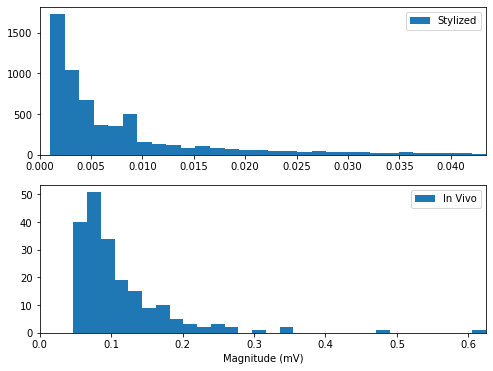

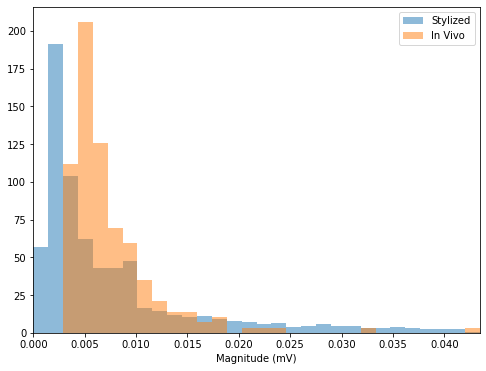

In [8]:
nbins = 30

plt.figure(figsize=(8, 6))
plt.subplot(211)
_, bins, _ = plt.hist(max_mag, bins=nbins, label='Stylized')
plt.xlim([0,bins[-1]])
plt.legend()
plt.subplot(212)
_, bins, _ = plt.hist(max_mag_invivo, bins=nbins, label='In Vivo')
plt.xlim([0,bins[-1]])
plt.legend()
plt.xlabel('Magnitude (mV)')

bins = np.linspace(0, max(np.amax(max_mag), np.amax(mag_scale * max_mag_invivo)), nbins + 1)
plt.figure(figsize=(8, 6))
plt.hist(max_mag, bins=bins, label='Stylized', density=True, alpha=0.5)
plt.hist(mag_scale * max_mag_invivo, bins=bins, label='In Vivo', density=True, alpha=0.5)
plt.xlim([0, bins[-1]])
plt.legend()
plt.xlabel('Magnitude (mV)')
plt.show()

## Load model

In [9]:
import torch
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
# from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork

model_name = 'FCN_batch256' # select model
if direction_vec:
    model_name += '_dv'
model_name += '.pth'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name)

model = FullyConnectedNetwork(in_features=n_summ_stats, out_features=len(label_list))
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device("cpu")
model.eval()

FullyConnectedNetwork(
  (hidden_layers): Sequential(
    (0): Linear(in_features=40, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=124, bias=True)
    (3): ReLU()
    (4): Linear(in_features=124, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): ReLU()
  )
  (output_layers): Linear(in_features=16, out_features=7, bias=True)
)

## Predict in vivo data

In [10]:
pred = model(torch.Tensor(invivo_stats_scaled).to(device)).to("cpu").detach().numpy()
for i, lb in enumerate(label_list):
    pred[:, i] = org_scale(pred[:, i], ranges[lb])
pred_list = label_list.copy()
pred_list = label_list.copy()
if has_yshift:
    pred[:, ys_idx] = y_c - pred[:, ys_idx]
    pred_list[pred_list.index('ys')] = 'y'
if direction_vec:
    pred[:, orient_idx1] = trivarnorm2unitsphere(pred[:, orient_idx1])
    pred = np.hstack([pred, unitsphere2hphi(pred[:, orient_idx1])[:, [1]]])
    pred_list[pred_list.index('vy')] = 'h'
    pred_list.append('phi')
loc_pred_dict = dict(zip(pred_list, pred.T))
loc_pred_dict['layer'] = layer

In [37]:
df_pred = pd.DataFrame(loc_pred_dict).sort_values(by='y')

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df_pred)

,y,d,theta,l_t,vx,h,vz,phi,layer
166,-1140.366577,176.490875,-0.228701,1193.354248,-0.505083,0.859737,0.075789,-1.421854,Layer6
130,-1138.140259,124.730331,0.296052,510.502747,-0.358793,0.933118,0.023633,-1.505022,Layer6
163,-1006.076904,159.117035,-0.588677,1508.682983,-0.709454,0.658067,0.252234,-1.229201,Layer6
125,-997.792358,167.590347,-0.418793,1311.370850,-0.691760,0.711042,0.126042,-1.390569,Layer6
11,-996.043579,190.081329,-0.570694,1573.900391,-0.747555,0.633377,0.199986,-1.309398,Layer6
168,-986.559570,149.869293,-0.691269,1432.873413,-0.728124,0.661089,0.181099,-1.327023,Layer6
6,-964.561279,266.689209,-0.166673,1648.016113,-0.786354,0.526666,0.322910,-1.181149,Layer6
131,-953.058350,126.262062,-0.524839,1222.215332,-0.648290,0.741357,0.173521,-1.309268,Layer6
3,-932.853943,134.537399,-0.198461,925.484924,-0.481033,0.860619,-0.167159,-1.905242,Layer6
129,-924.532898,173.996796,-0.552158,1607.009521,-0.749299,0.592493,0.295810,-1.194796,Layer6


,y,d,theta,l_t,vx,h,vz,phi,layer
0,-898.742554,204.503067,-0.245966,1461.550415,-0.622620,0.780045,0.062238,-1.471166,Layer6
1,-885.139099,187.555038,0.050766,1158.004761,-0.542237,0.820084,-0.182869,-1.896066,Layer6
2,-908.766357,211.502136,-0.426759,1536.988892,-0.704957,0.671038,0.229658,-1.255862,Layer6
3,-932.853943,134.537399,-0.198461,925.484924,-0.481033,0.860619,-0.167159,-1.905242,Layer6
4,-894.389465,230.029007,-0.285743,1553.185547,-0.708972,0.688766,0.151527,-1.360236,Layer6
...,...,...,...,...,...,...,...,...,...
193,624.148743,112.134171,-0.580024,920.915466,-0.368753,0.928338,0.047012,-1.443991,Layer2_3
194,643.515137,130.436462,-0.681359,1320.092651,-0.716383,0.675755,0.173639,-1.333000,Layer2_3
195,651.810791,190.174484,-0.070891,1355.562012,-0.598031,0.784084,0.166043,-1.299969,Layer2_3
196,499.367310,209.641113,-0.664724,1607.437744,-0.801125,0.520298,0.295785,-1.217110,Layer2_3


Text(0, 0.5, 'trunk_length')

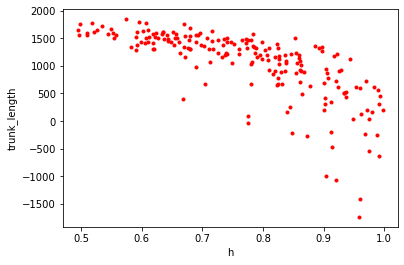

In [32]:
plt.figure()
plt.plot(loc_pred_dict['h'], loc_pred_dict['l_t'], 'r.')
plt.xlabel('h')
plt.ylabel('trunk_length')

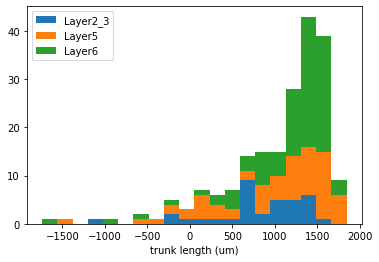

In [12]:
layer_type = np.unique(layer)
plt.figure()
plt.hist([loc_pred_dict['l_t'][layer==ly] for ly in layer_type], bins=20, label=layer_type, stacked=True)
plt.xlabel('trunk length (um)')
plt.legend()
plt.show()

# Select location parameter
To test on different parameters, run all cells below beginning from here after changing parameters.

In [13]:
# loc_param_select = {'y': 0., 'd': 80., 'theta': 0., 'alpha': np.pi*3/8, 'h': .85, 'phi': np.pi*3/5} # enter location parameters

# if 'd' in loc_param_select.keys() and 'theta' in loc_param_select.keys():
#     loc_param_select['x'], loc_param_select['z'] = pol2cart(loc_param_select['d'], loc_param_select['theta'])
# loc_param = np.array([loc_param_select[x] for x in loc_param_list])
# ycoord = loc_param[y_idx] if has_yshift else None

## Get ground truth

#### from detailed model

In [14]:
# if Initialize:
#     DETAILED_PATH = 'cell_inference/resources/detailed'
#     model_name = 'neuronal_model_491766131'
# #     file = os.path.join(DETAILED_PATH, model_name + '_Im.h5')
#     file = os.path.join(DETAILED_PATH, model_name + '_Im_strch.h5')

#     ecp_detailed = EcpMod(EcpCell(file=file), params.ELECTRODE_POSITION, move_cell=loc_param, min_distance = params.MIN_DISTANCE)

# detailed_lfp = ecp_detailed.calc_ecp(move_cell=loc_param).T

#### from stylized model

In [15]:
# if Initialize:
#     h.load_file('stdrun.hoc')
#     h.nrn_load_dll(paths.COMPILED_LIBRARY)
#     geo_standard = pd.read_csv(paths.GEO_STANDARD_OBLIQUE, index_col='id')
#     h.tstop = params.TSTOP
#     h.dt = params.DT

#     # Biophysical parameters
#     filepath = './cell_inference/resources/biophys_parameters/'+model_name+'.json'
#     with open(filepath) as f:
#         full_biophys = json.load(f)

#     # common parameters
#     biophys_param = [200, 50, 120] # Ra: basal, trunk, tuft
#     biophys_comm = {}

#     # geometry parameters
#     geo_param = [config_dict['Simulation_Parameters']['geo_param_default'][x] for x in config_dict['Simulation_Parameters']['geo_param_list']]

#     # Fixed gmax, not using gmax mapping file
#     gmax = 0.02

#     sim = Simulation(geometry = geo_standard,
#                      full_biophys = full_biophys,
#                      electrodes = params.ELECTRODE_POSITION,
#                      cell_type = CellTypes.ACTIVE_FULL,
#                      biophys = biophys_param,
#                      biophys_comm = biophys_comm,
#                      loc_param = loc_param,
#                      geo_param = geo_param,
#                      spike_threshold = params.SPIKE_THRESHOLD,
#                      gmax = gmax,
#                      stim_param = params.STIM_PARAM,
#                      min_distance = params.MIN_DISTANCE,
#                      ncell = 1)

#     sim.run_neuron_sim()
#     start_idx = int(np.ceil(params.STIM_PARAM['start']/h.dt)) # ignore signal before
#     Initialize = False

# stylized_lfp = sim.lfp[0].calc_ecp(move_cell=loc_param).T[start_idx:,:]

## Get prediction

In [16]:
# case_name = ['detailed ground truth', 'stylized ground truth']
# lfp = [detailed_lfp, stylized_lfp]
# output = [process_lfp(x, ycoord=ycoord) for x in lfp]
# loc_param_pred = len(lfp) * [loc_param_select]

# for i in range(len(lfp)):
#     out = output[i]
#     if not out[0]:
#         case_name.append('Predicted stylized from ' + case_name[i])
#         # model output
#         pred = model(torch.Tensor(out[6]).to(device)).to("cpu").detach().numpy()
#         for i, lb in enumerate(label_list):
#             pred[i] = org_scale(pred[i], ranges[lb])
#         # transform
#         pred_list = label_list.copy()
#         if has_yshift:
#             pred[ys_idx] = out[4] - pred[ys_idx]
#             pred_list[pred_list.index('ys')] = 'y'
#         if direction_vec:
#             pred[orient_idx1] = trivarnorm2unitsphere(pred[orient_idx1])
#             pred = np.hstack([pred, unitsphere2hphi(pred[orient_idx1])[:, 1]])
#             pred_list[pred_list.index('vy')] = 'h'
#             pred_list.append('phi')
#         loc_pred_dict = dict(zip(pred_list, pred))
#         # get loc parameters
#         if 'd' in loc_pred_dict.keys() and 'theta' in loc_pred_dict.keys():
#             loc_pred_dict['x'], loc_pred_dict['z'] = pol2cart(loc_pred_dict['d'], loc_pred_dict['theta'])
#         loc_param_pred.append(loc_pred_dict)
#         loc_pred = [loc_pred_dict[x] if x in loc_pred_dict.keys() else loc_param_select[x] for x in loc_param_list]
#         # get lfp
#         lfp.append(sim.lfp[0].calc_ecp(move_cell=loc_pred).T[start_idx:,:])
#         output.append(process_lfp(lfp[-1], ycoord=ycoord))

## Plot LFP

In [17]:
# %matplotlib inline

# ix = 1
# fontsize = 15
# labelpad = -10
# ticksize = 12
# tick_length = 5
# nbins = 5

# nlfp = len(lfp)
# plt.figure(figsize=(13, 4 * nlfp))
# for i, out in enumerate(output):
#     print("Case %d bad flag: %d" % (i, output[i][0]))
#     print(case_name[i])
#     print("Parameters: " + str(loc_param_pred[i]))
#     d = output[i][1]
#     t = output[i][2]
#     coords = output[i][3]
#     x_dist = np.unique(coords[:, 0])
#     e_idx = coords[:, 0]==x_dist[ix]

#     ax = plt.subplot(nlfp, 2, 2 * i + 1)
#     _ = plot_lfp_heatmap(t=t, elec_d=coords[e_idx, 1], lfp=d[:, e_idx],
#                          fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
#                          nbins=nbins, vlim='auto', axes = ax)
    
#     ax = plt.subplot(nlfp, 2, 2 * i + 2)
#     _ = plot_lfp_traces(t, d[:, e_idx], electrodes=coords[e_idx, :],
#                         fontsize=fontsize, labelpad=labelpad, ticksize=ticksize, tick_length=tick_length,
#                         nbins=nbins, axes = ax)
# plt.tight_layout(h_pad=0., w_pad=-0.5)
# plt.show()

## Plot morphology

In [18]:
# %matplotlib notebook

# _ = plot_morphology(sim, 0, electrodes=params.ELECTRODE_POSITION, move_cell=loc_param, elev=20, azim=-75, figsize=(10,8))